<a href="https://colab.research.google.com/github/fralfaro/MAT281/blob/main/docs/labs/lab_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MAT281 - Laboratorio N°10

**Objetivo**: Analizar y modelar series temporales de datos delictivos en Montreal, aplicando métodos estadísticos y de aprendizaje automático para la predicción.

> **Nota**: Puede ayudarse de algún asistente virtual como **ChatGPT, Gemini** u otros, así como del autocompletado de **Google Colab**, para avanzar en este laboratorio debido a su extensión.


### Conjunto de datos



<img src="https://svgsilh.com/svg/3350822.svg" width="350"  align="center"/>


El conjunto de datos **`interventionscitoyendo.csv`** proviene del *Service de police de la Ville de Montréal* (SPVM) y contiene el registro de todos los **actos delictivos ocurridos en Montreal entre 2015 y agosto de 2020**.

Cada incidente está clasificado en **categorías generales de delito** e incluye información contextual como la **ubicación geográfica**, la **fecha y hora** del suceso, así como otros atributos relevantes para el análisis.

Este dataset resulta especialmente útil para estudios de **series temporales**, ya que permite agrupar los delitos por intervalos de tiempo (días, semanas, meses) y analizar patrones de comportamiento delictual en la ciudad.

> **Nota**: Puede consultarse más información oficial en el [portal de datos abiertos de Montreal](https://donnees.montreal.ca/ville-de-montreal/actes-criminels).


In [ ]:
# librerias

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX


# graficos incrustados
plt.style.use('fivethirtyeight')
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (12, 4)})

In [17]:
# metrics


def mae(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute error (MAE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.abs(error).mean(), 4)


def mse(targets, predictions) -> float:
    """
    Calculo de la metrica: mean squared error (MSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round((error ** 2).mean(), 4)


def rmse(targets, predictions) -> float:
    """
    Calculo de la metrica: root mean squared error (RMSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.sqrt((error ** 2).mean()), 4)


# b) Percentage errors

def mape(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute percentage error (MAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets

    if any(x == 0 for x in targets):
        return np.inf
    else:
        return round(np.abs(error / targets).mean(),4)


def maape(targets, predictions) -> float:
    """
    Calculo de la metrica:  mean arctangent percentage error  (MAAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """

    error = predictions - targets

    if any((x, y) == (0, 0) for x, y in zip(predictions, targets)):
        return np.inf

    else:
        return round(np.arctan(np.abs(error / targets)).mean(),4)


def wmape(targets, predictions) -> float:
    """
    Calculo de la metrica:  weighted mean absolute percentage error (WMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.sum(targets)

    if sum_values == 0:
        return np.inf
    else:
        return round(np.abs(error).sum() / sum_values,4)


def mmape(targets, predictions) -> float:
    """
    Calculo de la metrica: modified mean absolute percentage error (MMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = np.abs(predictions - targets)
    denom = 1 + np.abs(targets)

    return round(np.mean(error / denom),4)


def smape(targets, predictions) -> float:
    """
    Calculo de la metrica: symmetric mean absolute percentage error (SMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.abs(predictions) + np.abs(targets)

    if any(x == 0 for x in sum_values):
        return np.inf

    else:
        return round(2 * np.mean(np.abs(error) / sum_values),4)

def summary_metrics(df) -> pd.DataFrame:
    """
    Aplicar las distintas metricas definidas
    :param df:  dataframe con las columnas: ['y','yhat']
    :return: dataframe con las metricas especificadas
    """
    df_result = pd.DataFrame()

    y_true = df['y']
    y_pred = df['yhat']

    df_result['mae'] = [round(mae(y_true, y_pred), 4)]
    df_result['mse'] = [round(mse(y_true, y_pred), 4)]
    df_result['rmse'] = [round(rmse(y_true, y_pred), 4)]

    df_result['mape'] = [round(mape(y_true, y_pred), 4)]
    df_result['maape'] = [round(maape(y_true, y_pred), 4)]
    df_result['wmape'] = [round(wmape(y_true, y_pred), 4)]
    df_result['mmape'] = [round(mmape(y_true, y_pred), 4)]
    df_result['smape'] = [round(smape(y_true, y_pred), 4)]

    # nombre del modelo por defecto
    #try:
    #    model = df['model'][0]
    #    df_result['model'] = [model]
    #except:
    #    df_result['model'] = ['---']

    return df_result

In [18]:
# read data

validate_categorie = [
  'Introduction', 'Méfait','Vol dans / sur véhicule à moteur', 'Vol de véhicule à moteur',
]

df = pd.read_csv("https://raw.githubusercontent.com/fralfaro/MAT281/main/docs/labs/data/interventionscitoyendo.csv", sep=",", encoding='latin-1')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df = df.loc[lambda x: x['categorie'].isin(validate_categorie)]
df = df.sort_values(['categorie','date'])
df.head()

,categorie,date,quart,pdq,x,y,longitude,latitude
3462,Introduction,2015-01-01,jour,42.0,297210.375006,5.050179e+06,-73.597273,45.591480
8370,Introduction,2015-01-01,soir,13.0,297145.531007,5.032845e+06,-73.597834,45.435501
11968,Introduction,2015-01-01,nuit,8.0,289215.072000,5.036423e+06,-73.699308,45.467564
12763,Introduction,2015-01-01,soir,27.0,293203.472992,5.045436e+06,-73.648516,45.548740
13686,Introduction,2015-01-01,soir,44.0,298915.433995,5.046912e+06,-73.575381,45.562090


Como tenemos muchos datos por categoría a nivel de día, agruparemos a nivel de **semanas** y separaremos cada serie temporal.

In [19]:
cols = ['date','pdq']
y_s1 = df.loc[lambda x: x.categorie == validate_categorie[0] ][cols].set_index('date').resample('W').mean()
y_s2 = df.loc[lambda x: x.categorie == validate_categorie[1] ][cols].set_index('date').resample('W').mean()
y_s3 = df.loc[lambda x: x.categorie == validate_categorie[2] ][cols].set_index('date').resample('W').mean()
y_s4 = df.loc[lambda x: x.categorie == validate_categorie[3] ][cols].set_index('date').resample('W').mean()



El objetivo de este laboratorio es realizar un **análisis integral** del conjunto de datos, aplicando técnicas de visualización y modelado de series temporales. Para ello, se deben abordar las siguientes tareas:

1. **Visualizar las series temporales** \$y\_{si}, ; i=1,2,3,4\$, generando gráficos que permitan identificar patrones, tendencias y estacionalidades.



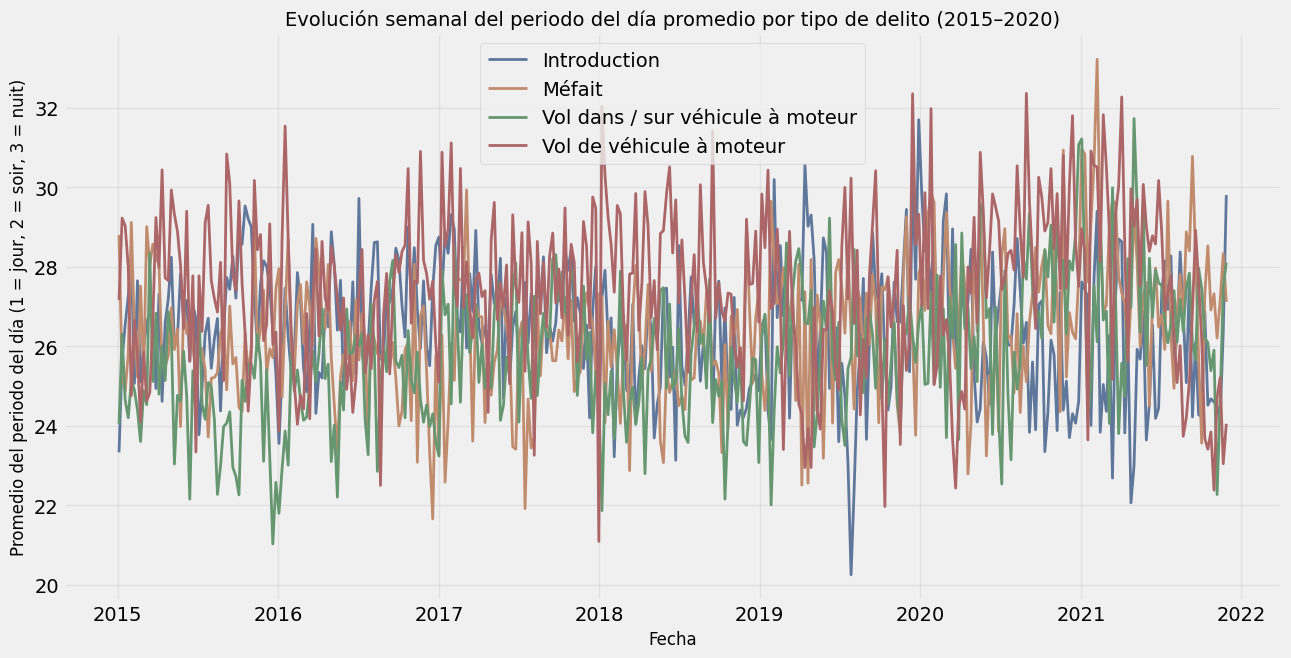

In [21]:

map_pdq = {'jour': 1, 'soir': 2, 'nuit': 3}
df['pdq'] = df['pdq'].map(map_pdq)

plt.figure(figsize=(14, 7))

plt.plot(y_s1.index, y_s1['pdq'], label=validate_categorie[0], linewidth=2)
plt.plot(y_s2.index, y_s2['pdq'], label=validate_categorie[1], linewidth=2)
plt.plot(y_s3.index, y_s3['pdq'], label=validate_categorie[2], linewidth=2)
plt.plot(y_s4.index, y_s4['pdq'], label=validate_categorie[3], linewidth=2)

plt.title("Evolución semanal del periodo del día promedio por tipo de delito (2015–2020)", fontsize=14)
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Promedio del periodo del día (1 = jour, 2 = soir, 3 = nuit)", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()





1. Seleccione una de las series temporales \$y\_{si}, ; i=1,2,3,4\$ y desarrolle lo siguiente:

* **Análisis exploratorio**: examine la serie elegida identificando patrones, tendencias y posibles estacionalidades.
* **Modelado con SARIMA**: ajuste un modelo \$SARIMA(p,d,q) \times (P,D,Q,S)\$ probando distintas configuraciones de hiperparámetros. Compare resultados, seleccione la mejor configuración y justifique su elección.
* **Validación del modelo**: evalúe los residuos del modelo óptimo y determine si se comportan como **ruido blanco**.

> **Nota**: Utilice como `target_date` = `'2021-01-01'`. Recuerde que la columna de valores se llama `pdq`.



In [24]:
# creando clase SarimaModels

class SarimaModels:
    def __init__(self,params):

        self.params = params


    @property
    def name_model(self):
        return f"SARIMA_{self.params[0]}X{self.params[1]}".replace(' ','')

    @staticmethod
    def test_train_model(y,date):
        mask_ds = y.index < date

        y_train = y[mask_ds]
        y_test = y[~mask_ds]

        return y_train, y_test

    def fit_model(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        return model_fit

    def df_testig(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        start_index = y_test.index.min()
        end_index = y_test.index.max()

        preds = model_fit.get_prediction(start=start_index,end=end_index, dynamic=False)
        df_temp = pd.DataFrame(
            {
                'y':y_test['pdq'],
                'yhat': preds.predicted_mean
            }
        )

        return df_temp

    def metrics(self,y,date):
        df_temp = self.df_testig(y,date)
        df_metrics = summary_metrics(df_temp)
        df_metrics['model'] = self.name_model

        return df_metrics

import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

params = list(itertools.product(pdq,seasonal_pdq))
target_date = '2021-01-01'

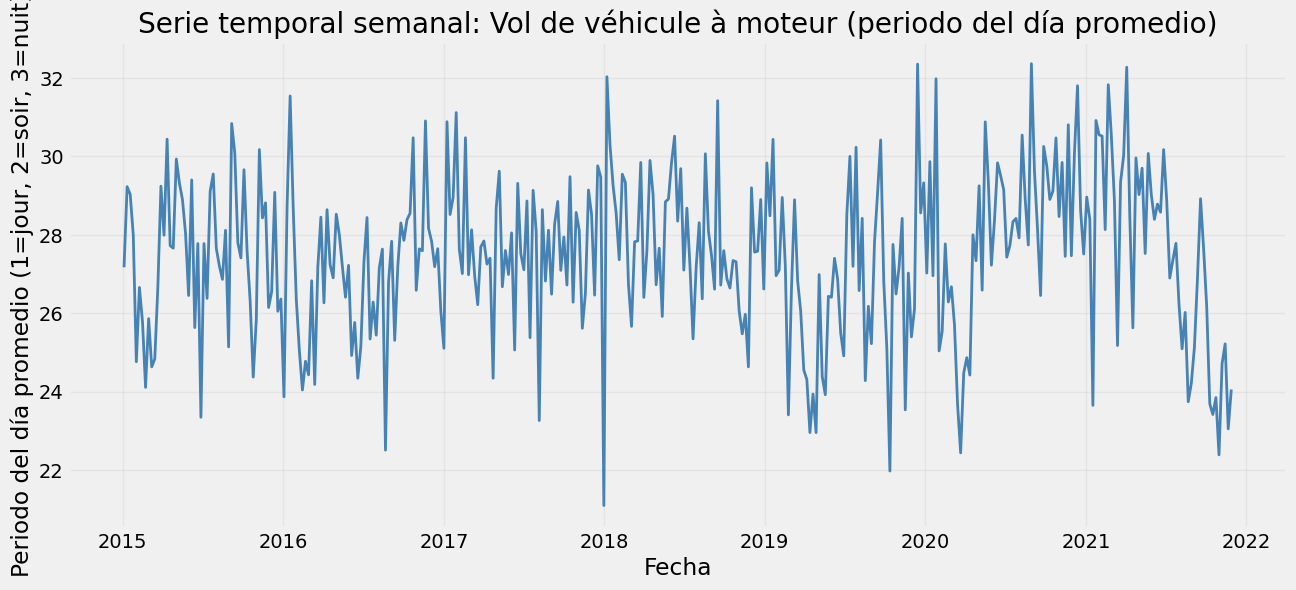

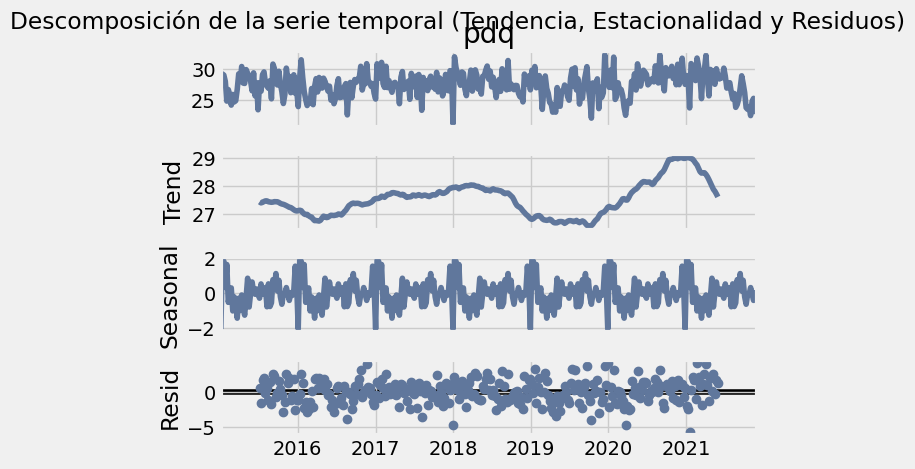

                                     SARIMAX Results                                      
Dep. Variable:                                pdq   No. Observations:                  313
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -605.271
Date:                            Wed, 12 Nov 2025   AIC                           1218.542
Time:                                    00:14:58   BIC                           1233.166
Sample:                                01-04-2015   HQIC                          1224.404
                                     - 12-27-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1073      0.064      1.688      0.091      -0.017       0.232
ma.L1         -0.9109      0.030   

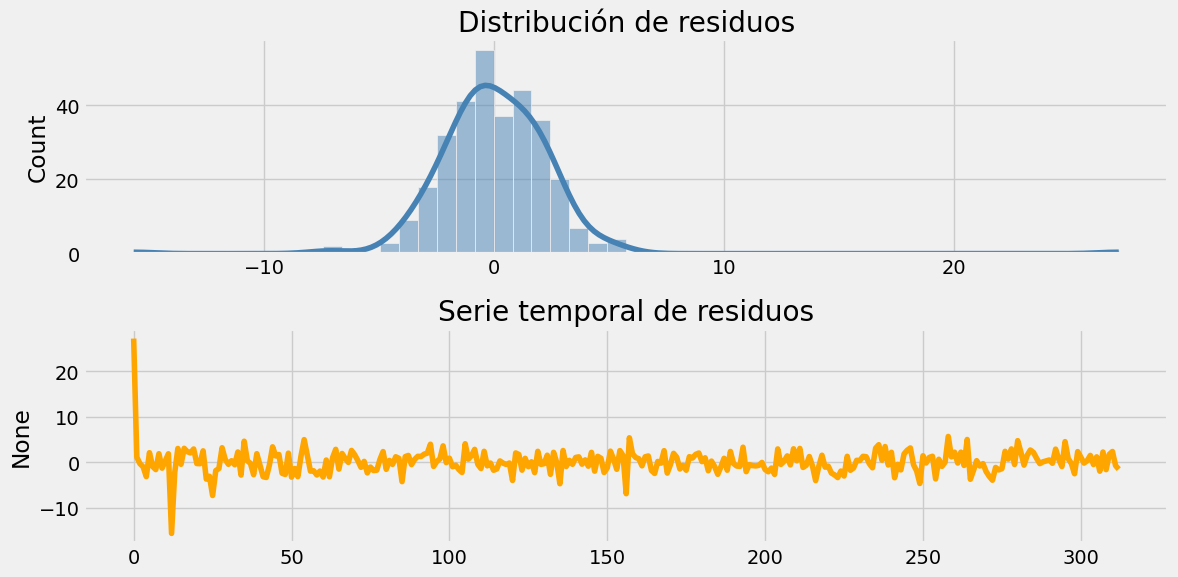

Test de Ljung-Box:
     lb_stat  lb_pvalue
10  6.260469   0.792926


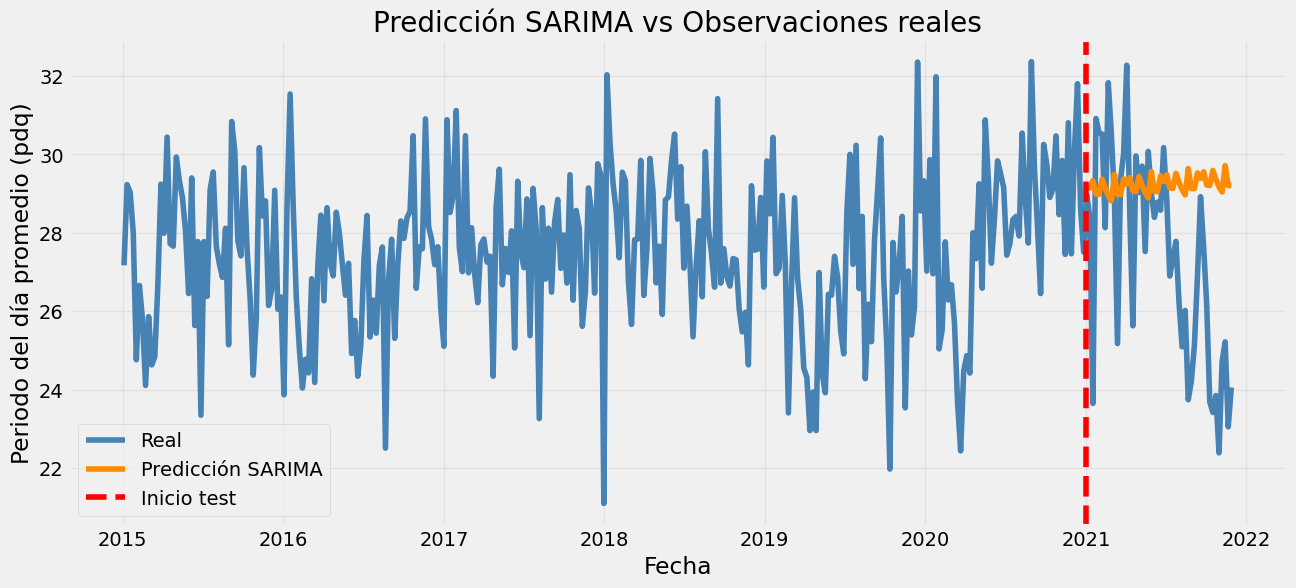

In [28]:

y = y_s4.copy()
plt.figure(figsize=(14,6))
plt.plot(y.index, y['pdq'], color='steelblue', linewidth=2)
plt.title("Serie temporal semanal: Vol de véhicule à moteur (periodo del día promedio)")
plt.xlabel("Fecha")
plt.ylabel("Periodo del día promedio (1=jour, 2=soir, 3=nuit)")
plt.grid(True, alpha=0.3)
plt.show()
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(y['pdq'], model='additive', period=52)
decomp.plot()
plt.suptitle("Descomposición de la serie temporal (Tendencia, Estacionalidad y Residuos)")
plt.show()
results = []
for param in params[:10]:
    try:
        model_sarima = SarimaModels(param)
        df_metrics = model_sarima.metrics(y, target_date)
        results.append(df_metrics)
    except Exception as e:
        print(f"Error con {param}: {e}")

df_results = pd.concat(results).sort_values('rmse').reset_index(drop=True)
df_results
best_params = ((1,1,1), (0,1,1,12))
best_model = SarimaModels(best_params)
model_fit = best_model.fit_model(y, target_date)
print(model_fit.summary())
residuals = model_fit.resid
fig, ax = plt.subplots(2, 1, figsize=(12,6))
sns.histplot(residuals, kde=True, ax=ax[0], color='steelblue')
ax[0].set_title("Distribución de residuos")
sns.lineplot(x=range(len(residuals)), y=residuals, ax=ax[1], color='orange')
ax[1].set_title("Serie temporal de residuos")
plt.tight_layout()
plt.show()
from statsmodels.stats.diagnostic import acorr_ljungbox
test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("Test de Ljung-Box:")
print(test)
df_pred = best_model.df_testig(y, target_date)
plt.figure(figsize=(14,6))
plt.plot(y.index, y['pdq'], label='Real', color='steelblue')
plt.plot(df_pred.index, df_pred['yhat'], label='Predicción SARIMA', color='darkorange')
plt.axvline(pd.to_datetime(target_date), color='red', linestyle='--', label='Inicio test')
plt.title("Predicción SARIMA vs Observaciones reales")
plt.xlabel("Fecha")
plt.ylabel("Periodo del día promedio (pdq)")
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()




3. Resuelva el ejercicio anterior utilizando la librería **`Prophet`**, desarrollada por Facebook para el modelado de series temporales.

* **Ajuste del modelo**: entrene un modelo con `Prophet` sobre la misma serie seleccionada en el punto anterior.
* **Evaluación del desempeño**: compare la capacidad predictiva de `Prophet` frente al modelo **SARIMA** previamente ajustado, considerando métricas de error (por ejemplo, MAE, RMSE o MAPE).
* **Análisis comparativo**: discuta las diferencias en los supuestos de ambos métodos, su facilidad de implementación y la calidad de las predicciones obtenidas.
* **Conclusiones**: señale en qué situaciones `Prophet` puede ser preferible a SARIMA y viceversa.


In [33]:
from prophet import Prophet

df_prophet = y_s4.reset_index()[['date', 'pdq']]
df_prophet.columns = ['ds', 'y']
train = df_prophet[df_prophet['ds'] < target_date]
test  = df_prophet[df_prophet['ds'] >= target_date]
print(f"Tamaño train: {len(train)}, test: {len(test)}")
model_prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.5
)
model_prophet.fit(train)

future = model_prophet.make_future_dataframe(periods=len(test), freq='W')
forecast = model_prophet.predict(future)
fig1 = model_prophet.plot(forecast)
plt.title("Predicción Prophet: Vol de véhicule à moteur")
plt.xlabel("Fecha")
plt.ylabel("Periodo del día promedio (pdq)")
plt.show()

fig2 = model_prophet.plot_components(forecast)
plt.show()
df_eval = forecast.set_index('ds')[['yhat']].join(test.set_index('ds'))
df_eval = df_eval.dropna()
metrics_prophet = summary_metrics(
    pd.DataFrame({'y': df_eval['y'], 'yhat': df_eval['yhat']})
)
metrics_prophet['model'] = 'Prophet'
metrics_sarima = df_results.iloc[0].copy()
metrics_sarima['model'] = 'SARIMA (mejor)'
df_compare = pd.concat([metrics_sarima.to_frame().T, metrics_prophet])
df_compare = df_compare[['model', 'mae', 'rmse', 'mape', 'wmape']]
df_compare

Tamaño train: 313, test: 48


AttributeError: 'Prophet' object has no attribute 'stan_backend'